<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[04:09:58] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


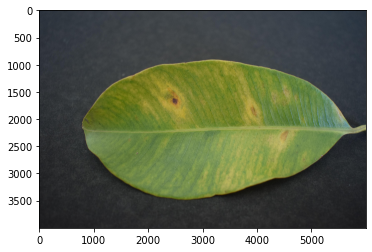

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

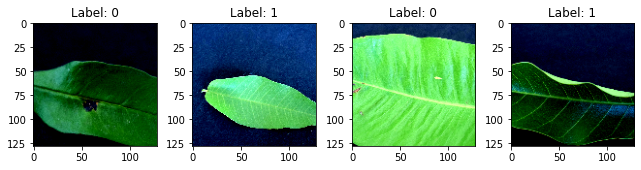

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[04:10:06] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[04:10:08] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2485685034212213 samples/sec                   batch loss = 0.45197635889053345 | accuracy = 0.6


Epoch[1] Batch[10] Speed: 1.2671383600297275 samples/sec                   batch loss = 0.5935125350952148 | accuracy = 0.575


Epoch[1] Batch[15] Speed: 1.265230801159741 samples/sec                   batch loss = 0.43172788619995117 | accuracy = 0.5833333333333334


Epoch[1] Batch[20] Speed: 1.264640549189301 samples/sec                   batch loss = 0.8374301195144653 | accuracy = 0.575


Epoch[1] Batch[25] Speed: 1.2631745063239979 samples/sec                   batch loss = 0.6423521041870117 | accuracy = 0.59


Epoch[1] Batch[30] Speed: 1.2615163295723681 samples/sec                   batch loss = 0.8543164730072021 | accuracy = 0.5666666666666667


Epoch[1] Batch[35] Speed: 1.2624591457467256 samples/sec                   batch loss = 0.35716238617897034 | accuracy = 0.6


Epoch[1] Batch[40] Speed: 1.263280367902987 samples/sec                   batch loss = 0.35870081186294556 | accuracy = 0.60625


Epoch[1] Batch[45] Speed: 1.2696932357106672 samples/sec                   batch loss = 0.6530866622924805 | accuracy = 0.6166666666666667


Epoch[1] Batch[50] Speed: 1.2710919218629086 samples/sec                   batch loss = 0.7289841175079346 | accuracy = 0.62


Epoch[1] Batch[55] Speed: 1.2654688125579474 samples/sec                   batch loss = 0.7420440316200256 | accuracy = 0.6272727272727273


Epoch[1] Batch[60] Speed: 1.2626389076827695 samples/sec                   batch loss = 0.41841670870780945 | accuracy = 0.65


Epoch[1] Batch[65] Speed: 1.2657029985466142 samples/sec                   batch loss = 0.8993619680404663 | accuracy = 0.6461538461538462


Epoch[1] Batch[70] Speed: 1.2665858171996773 samples/sec                   batch loss = 0.8364018797874451 | accuracy = 0.6321428571428571


Epoch[1] Batch[75] Speed: 1.265337007693364 samples/sec                   batch loss = 0.40596073865890503 | accuracy = 0.64


Epoch[1] Batch[80] Speed: 1.2695399908272245 samples/sec                   batch loss = 1.0234650373458862 | accuracy = 0.634375


Epoch[1] Batch[85] Speed: 1.2662810535636706 samples/sec                   batch loss = 0.8700075149536133 | accuracy = 0.6235294117647059


Epoch[1] Batch[90] Speed: 1.2680286455751002 samples/sec                   batch loss = 1.0178605318069458 | accuracy = 0.6222222222222222


Epoch[1] Batch[95] Speed: 1.2660576406881554 samples/sec                   batch loss = 0.7266879081726074 | accuracy = 0.6210526315789474


Epoch[1] Batch[100] Speed: 1.2680868219758876 samples/sec                   batch loss = 0.8656809329986572 | accuracy = 0.61


Epoch[1] Batch[105] Speed: 1.273956404933262 samples/sec                   batch loss = 0.8065430521965027 | accuracy = 0.6023809523809524


Epoch[1] Batch[110] Speed: 1.2707724730760583 samples/sec                   batch loss = 0.7457709908485413 | accuracy = 0.6045454545454545


Epoch[1] Batch[115] Speed: 1.268363496489233 samples/sec                   batch loss = 0.6579079627990723 | accuracy = 0.6021739130434782


Epoch[1] Batch[120] Speed: 1.2660128338257493 samples/sec                   batch loss = 0.7283868789672852 | accuracy = 0.5979166666666667


Epoch[1] Batch[125] Speed: 1.2622272980505584 samples/sec                   batch loss = 0.6709122061729431 | accuracy = 0.602


Epoch[1] Batch[130] Speed: 1.2663098220282842 samples/sec                   batch loss = 0.761023759841919 | accuracy = 0.6076923076923076


Epoch[1] Batch[135] Speed: 1.2690886378581128 samples/sec                   batch loss = 1.4538003206253052 | accuracy = 0.6055555555555555


Epoch[1] Batch[140] Speed: 1.2636766740656995 samples/sec                   batch loss = 0.7559297680854797 | accuracy = 0.6089285714285714


Epoch[1] Batch[145] Speed: 1.2682856396187465 samples/sec                   batch loss = 0.38090744614601135 | accuracy = 0.6086206896551725


Epoch[1] Batch[150] Speed: 1.2644058032441987 samples/sec                   batch loss = 0.6051812171936035 | accuracy = 0.6133333333333333


Epoch[1] Batch[155] Speed: 1.262160542467014 samples/sec                   batch loss = 0.5601728558540344 | accuracy = 0.614516129032258


Epoch[1] Batch[160] Speed: 1.2630606749913518 samples/sec                   batch loss = 0.2812711000442505 | accuracy = 0.6125


Epoch[1] Batch[165] Speed: 1.2687429457945876 samples/sec                   batch loss = 0.5293376445770264 | accuracy = 0.6106060606060606


Epoch[1] Batch[170] Speed: 1.2634932861450485 samples/sec                   batch loss = 0.6015461087226868 | accuracy = 0.6132352941176471


Epoch[1] Batch[175] Speed: 1.259983704610811 samples/sec                   batch loss = 0.987445056438446 | accuracy = 0.6114285714285714


Epoch[1] Batch[180] Speed: 1.2661365619789904 samples/sec                   batch loss = 0.3980920910835266 | accuracy = 0.6180555555555556


Epoch[1] Batch[185] Speed: 1.2656555433445043 samples/sec                   batch loss = 0.6570084691047668 | accuracy = 0.6229729729729729


Epoch[1] Batch[190] Speed: 1.260778021608722 samples/sec                   batch loss = 0.43507131934165955 | accuracy = 0.625


Epoch[1] Batch[195] Speed: 1.2636192822942758 samples/sec                   batch loss = 0.47368842363357544 | accuracy = 0.6256410256410256


Epoch[1] Batch[200] Speed: 1.2631095524319234 samples/sec                   batch loss = 0.28892695903778076 | accuracy = 0.62875


Epoch[1] Batch[205] Speed: 1.261432197708098 samples/sec                   batch loss = 0.6328957080841064 | accuracy = 0.624390243902439


Epoch[1] Batch[210] Speed: 1.2630640031017206 samples/sec                   batch loss = 0.5013512372970581 | accuracy = 0.6238095238095238


Epoch[1] Batch[215] Speed: 1.2625788546614878 samples/sec                   batch loss = 1.219240665435791 | accuracy = 0.6232558139534884


Epoch[1] Batch[220] Speed: 1.2601143018690866 samples/sec                   batch loss = 0.5704593658447266 | accuracy = 0.6261363636363636


Epoch[1] Batch[225] Speed: 1.264249449624901 samples/sec                   batch loss = 0.4273115396499634 | accuracy = 0.63


Epoch[1] Batch[230] Speed: 1.265239102375809 samples/sec                   batch loss = 0.6080186367034912 | accuracy = 0.6315217391304347


Epoch[1] Batch[235] Speed: 1.2546565540621235 samples/sec                   batch loss = 0.45661187171936035 | accuracy = 0.6329787234042553


Epoch[1] Batch[240] Speed: 1.2662722608054042 samples/sec                   batch loss = 0.5809851884841919 | accuracy = 0.6354166666666666


Epoch[1] Batch[245] Speed: 1.267027162229498 samples/sec                   batch loss = 1.6789385080337524 | accuracy = 0.6357142857142857


Epoch[1] Batch[250] Speed: 1.267251108877653 samples/sec                   batch loss = 0.4776073396205902 | accuracy = 0.637


Epoch[1] Batch[255] Speed: 1.265286144657819 samples/sec                   batch loss = 0.4689233601093292 | accuracy = 0.6392156862745098


Epoch[1] Batch[260] Speed: 1.2616445882332947 samples/sec                   batch loss = 1.122703194618225 | accuracy = 0.6394230769230769


Epoch[1] Batch[265] Speed: 1.261412849915006 samples/sec                   batch loss = 0.3214734196662903 | accuracy = 0.6415094339622641


Epoch[1] Batch[270] Speed: 1.2639492371614223 samples/sec                   batch loss = 0.4480709731578827 | accuracy = 0.6462962962962963


Epoch[1] Batch[275] Speed: 1.2643322426720993 samples/sec                   batch loss = 0.6932868957519531 | accuracy = 0.6463636363636364


Epoch[1] Batch[280] Speed: 1.2629228115459934 samples/sec                   batch loss = 0.6276312470436096 | accuracy = 0.6446428571428572


Epoch[1] Batch[285] Speed: 1.2636117636922024 samples/sec                   batch loss = 0.34318235516548157 | accuracy = 0.6464912280701754


Epoch[1] Batch[290] Speed: 1.2630079980944837 samples/sec                   batch loss = 0.4481513798236847 | accuracy = 0.6474137931034483


Epoch[1] Batch[295] Speed: 1.2580576101532348 samples/sec                   batch loss = 0.5212151408195496 | accuracy = 0.6474576271186441


Epoch[1] Batch[300] Speed: 1.2591754559639508 samples/sec                   batch loss = 0.4649587869644165 | accuracy = 0.6508333333333334


Epoch[1] Batch[305] Speed: 1.2707407102756056 samples/sec                   batch loss = 0.9485822319984436 | accuracy = 0.6491803278688525


Epoch[1] Batch[310] Speed: 1.2645274065846834 samples/sec                   batch loss = 0.46425697207450867 | accuracy = 0.6516129032258065


Epoch[1] Batch[315] Speed: 1.2607732843649293 samples/sec                   batch loss = 0.6210352182388306 | accuracy = 0.65


Epoch[1] Batch[320] Speed: 1.2564840617981188 samples/sec                   batch loss = 0.3887878656387329 | accuracy = 0.64921875


Epoch[1] Batch[325] Speed: 1.2611693460939546 samples/sec                   batch loss = 0.5025305151939392 | accuracy = 0.6484615384615384


Epoch[1] Batch[330] Speed: 1.2655627438573813 samples/sec                   batch loss = 0.4299594461917877 | accuracy = 0.6484848484848484


Epoch[1] Batch[335] Speed: 1.256801073806841 samples/sec                   batch loss = 0.3424527943134308 | accuracy = 0.6529850746268657


Epoch[1] Batch[340] Speed: 1.2569361913623067 samples/sec                   batch loss = 0.4318985044956207 | accuracy = 0.6514705882352941


Epoch[1] Batch[345] Speed: 1.2619452254976897 samples/sec                   batch loss = 0.5984981060028076 | accuracy = 0.6514492753623189


Epoch[1] Batch[350] Speed: 1.2630526875980241 samples/sec                   batch loss = 0.5663833022117615 | accuracy = 0.6507142857142857


Epoch[1] Batch[355] Speed: 1.2685374625055867 samples/sec                   batch loss = 1.0372161865234375 | accuracy = 0.6507042253521127


Epoch[1] Batch[360] Speed: 1.2672867179456577 samples/sec                   batch loss = 0.9064131379127502 | accuracy = 0.6513888888888889


Epoch[1] Batch[365] Speed: 1.2555060794762458 samples/sec                   batch loss = 0.8769519925117493 | accuracy = 0.6513698630136986


Epoch[1] Batch[370] Speed: 1.2617612959160283 samples/sec                   batch loss = 0.8559407591819763 | accuracy = 0.652027027027027


Epoch[1] Batch[375] Speed: 1.2586620333015615 samples/sec                   batch loss = 0.6137605309486389 | accuracy = 0.6546666666666666


Epoch[1] Batch[380] Speed: 1.2678348905302106 samples/sec                   batch loss = 0.5539875626564026 | accuracy = 0.6552631578947369


Epoch[1] Batch[385] Speed: 1.2565900284195257 samples/sec                   batch loss = 0.37308353185653687 | accuracy = 0.6571428571428571


Epoch[1] Batch[390] Speed: 1.266795164267851 samples/sec                   batch loss = 0.47491180896759033 | accuracy = 0.658974358974359


Epoch[1] Batch[395] Speed: 1.2623552264159235 samples/sec                   batch loss = 0.19948968291282654 | accuracy = 0.6594936708860759


Epoch[1] Batch[400] Speed: 1.2687509093719533 samples/sec                   batch loss = 0.4162086546421051 | accuracy = 0.659375


Epoch[1] Batch[405] Speed: 1.261418350697756 samples/sec                   batch loss = 0.7383318543434143 | accuracy = 0.6604938271604939


Epoch[1] Batch[410] Speed: 1.2628790818444557 samples/sec                   batch loss = 0.22689607739448547 | accuracy = 0.6628048780487805


Epoch[1] Batch[415] Speed: 1.2613667590343847 samples/sec                   batch loss = 1.052262783050537 | accuracy = 0.6626506024096386


Epoch[1] Batch[420] Speed: 1.2631696559489993 samples/sec                   batch loss = 0.6115386486053467 | accuracy = 0.6642857142857143


Epoch[1] Batch[425] Speed: 1.265843188818411 samples/sec                   batch loss = 0.5417327880859375 | accuracy = 0.6641176470588235


Epoch[1] Batch[430] Speed: 1.2639340969726391 samples/sec                   batch loss = 0.45514363050460815 | accuracy = 0.6645348837209303


Epoch[1] Batch[435] Speed: 1.2584740562803776 samples/sec                   batch loss = 0.9014139175415039 | accuracy = 0.6626436781609195


Epoch[1] Batch[440] Speed: 1.2630312932921608 samples/sec                   batch loss = 0.6422406435012817 | accuracy = 0.6630681818181818


Epoch[1] Batch[445] Speed: 1.26968843123413 samples/sec                   batch loss = 0.7592546939849854 | accuracy = 0.6640449438202247


Epoch[1] Batch[450] Speed: 1.2675874646378478 samples/sec                   batch loss = 0.679291307926178 | accuracy = 0.6644444444444444


Epoch[1] Batch[455] Speed: 1.268380756695769 samples/sec                   batch loss = 0.28217819333076477 | accuracy = 0.6664835164835164


Epoch[1] Batch[460] Speed: 1.2709394945290915 samples/sec                   batch loss = 0.4456866681575775 | accuracy = 0.6657608695652174


Epoch[1] Batch[465] Speed: 1.2657120698656221 samples/sec                   batch loss = 0.4332146644592285 | accuracy = 0.6661290322580645


Epoch[1] Batch[470] Speed: 1.2684231420849246 samples/sec                   batch loss = 0.3711600601673126 | accuracy = 0.6675531914893617


Epoch[1] Batch[475] Speed: 1.2655956803890414 samples/sec                   batch loss = 0.6855226755142212 | accuracy = 0.6663157894736842


Epoch[1] Batch[480] Speed: 1.2649482431190626 samples/sec                   batch loss = 0.47999322414398193 | accuracy = 0.6671875


Epoch[1] Batch[485] Speed: 1.2598162390527794 samples/sec                   batch loss = 0.45047450065612793 | accuracy = 0.668041237113402


Epoch[1] Batch[490] Speed: 1.2647789786293024 samples/sec                   batch loss = 0.7146015167236328 | accuracy = 0.6678571428571428


Epoch[1] Batch[495] Speed: 1.2705295761421895 samples/sec                   batch loss = 0.7903110980987549 | accuracy = 0.6691919191919192


Epoch[1] Batch[500] Speed: 1.262661524067101 samples/sec                   batch loss = 0.7094364166259766 | accuracy = 0.671


Epoch[1] Batch[505] Speed: 1.2588572451602864 samples/sec                   batch loss = 0.4625144600868225 | accuracy = 0.6707920792079208


Epoch[1] Batch[510] Speed: 1.266866141839307 samples/sec                   batch loss = 0.8841060996055603 | accuracy = 0.6715686274509803


Epoch[1] Batch[515] Speed: 1.2621550352092863 samples/sec                   batch loss = 0.24248726665973663 | accuracy = 0.6733009708737864


Epoch[1] Batch[520] Speed: 1.264162666713685 samples/sec                   batch loss = 0.5558924078941345 | accuracy = 0.6735576923076924


Epoch[1] Batch[525] Speed: 1.260058368859407 samples/sec                   batch loss = 0.34160315990448 | accuracy = 0.6738095238095239


Epoch[1] Batch[530] Speed: 1.2628786065382502 samples/sec                   batch loss = 0.4196303188800812 | accuracy = 0.6726415094339623


Epoch[1] Batch[535] Speed: 1.2698993819983313 samples/sec                   batch loss = 0.5535154938697815 | accuracy = 0.6728971962616822


Epoch[1] Batch[540] Speed: 1.262328631896257 samples/sec                   batch loss = 0.5882925391197205 | accuracy = 0.674074074074074


Epoch[1] Batch[545] Speed: 1.2631944788488236 samples/sec                   batch loss = 0.38282278180122375 | accuracy = 0.673394495412844


Epoch[1] Batch[550] Speed: 1.257315994281935 samples/sec                   batch loss = 0.6048300862312317 | accuracy = 0.6731818181818182


Epoch[1] Batch[555] Speed: 1.2577908822318202 samples/sec                   batch loss = 0.46432197093963623 | accuracy = 0.6747747747747748


Epoch[1] Batch[560] Speed: 1.2548308158008068 samples/sec                   batch loss = 0.584168553352356 | accuracy = 0.6745535714285714


Epoch[1] Batch[565] Speed: 1.2588566784199462 samples/sec                   batch loss = 0.6054224371910095 | accuracy = 0.6738938053097345


Epoch[1] Batch[570] Speed: 1.2600604508790794 samples/sec                   batch loss = 0.48238900303840637 | accuracy = 0.6736842105263158


Epoch[1] Batch[575] Speed: 1.2607876856964475 samples/sec                   batch loss = 0.15751449763774872 | accuracy = 0.6752173913043479


Epoch[1] Batch[580] Speed: 1.2602482394911056 samples/sec                   batch loss = 0.6779075264930725 | accuracy = 0.6754310344827587


Epoch[1] Batch[585] Speed: 1.2495893099632778 samples/sec                   batch loss = 0.6787927150726318 | accuracy = 0.6764957264957265


Epoch[1] Batch[590] Speed: 1.2552652262639374 samples/sec                   batch loss = 0.9149925708770752 | accuracy = 0.6775423728813559


Epoch[1] Batch[595] Speed: 1.263881156774239 samples/sec                   batch loss = 0.2925848364830017 | accuracy = 0.6789915966386555


Epoch[1] Batch[600] Speed: 1.2563149851205309 samples/sec                   batch loss = 0.3311960697174072 | accuracy = 0.6795833333333333


Epoch[1] Batch[605] Speed: 1.2657977286251223 samples/sec                   batch loss = 0.8364052772521973 | accuracy = 0.6801652892561983


Epoch[1] Batch[610] Speed: 1.2579708262798173 samples/sec                   batch loss = 0.5662089586257935 | accuracy = 0.6819672131147541


Epoch[1] Batch[615] Speed: 1.261195038516432 samples/sec                   batch loss = 0.6020109057426453 | accuracy = 0.6833333333333333


Epoch[1] Batch[620] Speed: 1.2569519177316568 samples/sec                   batch loss = 0.2409639060497284 | accuracy = 0.6826612903225806


Epoch[1] Batch[625] Speed: 1.2633646513510117 samples/sec                   batch loss = 0.5947669744491577 | accuracy = 0.6832


Epoch[1] Batch[630] Speed: 1.262512821936813 samples/sec                   batch loss = 0.44623857736587524 | accuracy = 0.682936507936508


Epoch[1] Batch[635] Speed: 1.2599362042066173 samples/sec                   batch loss = 0.8894955515861511 | accuracy = 0.6838582677165355


Epoch[1] Batch[640] Speed: 1.2670206555616559 samples/sec                   batch loss = 0.5440441370010376 | accuracy = 0.684375


Epoch[1] Batch[645] Speed: 1.2603141302104006 samples/sec                   batch loss = 0.4131234586238861 | accuracy = 0.6848837209302325


Epoch[1] Batch[650] Speed: 1.26071587180044 samples/sec                   batch loss = 1.358211874961853 | accuracy = 0.685


Epoch[1] Batch[655] Speed: 1.2558526794559832 samples/sec                   batch loss = 0.9390116930007935 | accuracy = 0.6851145038167938


Epoch[1] Batch[660] Speed: 1.2619351639795073 samples/sec                   batch loss = 0.13359719514846802 | accuracy = 0.6859848484848485


Epoch[1] Batch[665] Speed: 1.2597623189420024 samples/sec                   batch loss = 0.5253686904907227 | accuracy = 0.6860902255639098


Epoch[1] Batch[670] Speed: 1.2608654775238235 samples/sec                   batch loss = 0.2420242428779602 | accuracy = 0.6865671641791045


Epoch[1] Batch[675] Speed: 1.2591451207422595 samples/sec                   batch loss = 0.3351629972457886 | accuracy = 0.6874074074074074


Epoch[1] Batch[680] Speed: 1.2593260196735163 samples/sec                   batch loss = 0.8507781028747559 | accuracy = 0.6878676470588235


Epoch[1] Batch[685] Speed: 1.2638182246463905 samples/sec                   batch loss = 0.49078384041786194 | accuracy = 0.6883211678832116


Epoch[1] Batch[690] Speed: 1.2661599727285167 samples/sec                   batch loss = 1.0622164011001587 | accuracy = 0.6880434782608695


Epoch[1] Batch[695] Speed: 1.2614917622873933 samples/sec                   batch loss = 0.34082746505737305 | accuracy = 0.6888489208633094


Epoch[1] Batch[700] Speed: 1.2621801031157098 samples/sec                   batch loss = 0.9438841342926025 | accuracy = 0.6889285714285714


Epoch[1] Batch[705] Speed: 1.2630563009301115 samples/sec                   batch loss = 0.6238771677017212 | accuracy = 0.6886524822695036


Epoch[1] Batch[710] Speed: 1.269279991526642 samples/sec                   batch loss = 0.4318001866340637 | accuracy = 0.6890845070422535


Epoch[1] Batch[715] Speed: 1.2615636646068986 samples/sec                   batch loss = 0.17512287199497223 | accuracy = 0.6902097902097902


Epoch[1] Batch[720] Speed: 1.268955310082638 samples/sec                   batch loss = 0.5786638855934143 | accuracy = 0.6902777777777778


Epoch[1] Batch[725] Speed: 1.2676623623219057 samples/sec                   batch loss = 0.8927372097969055 | accuracy = 0.69


Epoch[1] Batch[730] Speed: 1.2572810375503802 samples/sec                   batch loss = 0.6061097383499146 | accuracy = 0.690068493150685


Epoch[1] Batch[735] Speed: 1.260909067884014 samples/sec                   batch loss = 1.512459635734558 | accuracy = 0.6901360544217687


Epoch[1] Batch[740] Speed: 1.263665633120945 samples/sec                   batch loss = 0.5024860501289368 | accuracy = 0.6912162162162162


Epoch[1] Batch[745] Speed: 1.2638326956246881 samples/sec                   batch loss = 0.32335883378982544 | accuracy = 0.6929530201342282


Epoch[1] Batch[750] Speed: 1.2650624149494565 samples/sec                   batch loss = 0.39412373304367065 | accuracy = 0.693


Epoch[1] Batch[755] Speed: 1.2632963485505486 samples/sec                   batch loss = 0.5653268098831177 | accuracy = 0.6920529801324503


Epoch[1] Batch[760] Speed: 1.265145600721509 samples/sec                   batch loss = 0.7942371368408203 | accuracy = 0.6924342105263158


Epoch[1] Batch[765] Speed: 1.2577077179469514 samples/sec                   batch loss = 0.49053531885147095 | accuracy = 0.6928104575163399


Epoch[1] Batch[770] Speed: 1.266043405328422 samples/sec                   batch loss = 0.40493693947792053 | accuracy = 0.6941558441558442


Epoch[1] Batch[775] Speed: 1.2570138853404114 samples/sec                   batch loss = 0.8909098505973816 | accuracy = 0.694516129032258


Epoch[1] Batch[780] Speed: 1.26229899932285 samples/sec                   batch loss = 0.8801184892654419 | accuracy = 0.6942307692307692


Epoch[1] Batch[785] Speed: 1.2581140260922756 samples/sec                   batch loss = 0.5474700927734375 | accuracy = 0.6942675159235668


[Epoch 1] training: accuracy=0.694479695431472
[Epoch 1] time cost: 651.6661214828491
[Epoch 1] validation: validation accuracy=0.7822222222222223


Epoch[2] Batch[5] Speed: 1.263677911424979 samples/sec                   batch loss = 0.447813481092453 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.2612037609052464 samples/sec                   batch loss = 0.30177441239356995 | accuracy = 0.775


Epoch[2] Batch[15] Speed: 1.260781716683594 samples/sec                   batch loss = 0.7116691470146179 | accuracy = 0.7833333333333333


Epoch[2] Batch[20] Speed: 1.2624577207773244 samples/sec                   batch loss = 0.26377972960472107 | accuracy = 0.7625


Epoch[2] Batch[25] Speed: 1.2579639406808318 samples/sec                   batch loss = 0.3980105519294739 | accuracy = 0.8


Epoch[2] Batch[30] Speed: 1.261954432876615 samples/sec                   batch loss = 0.3331948518753052 | accuracy = 0.825


Epoch[2] Batch[35] Speed: 1.2628837398642032 samples/sec                   batch loss = 0.16173911094665527 | accuracy = 0.8214285714285714


Epoch[2] Batch[40] Speed: 1.2613750096235277 samples/sec                   batch loss = 0.3907100260257721 | accuracy = 0.80625


Epoch[2] Batch[45] Speed: 1.2503019890925466 samples/sec                   batch loss = 0.7018592953681946 | accuracy = 0.8


Epoch[2] Batch[50] Speed: 1.2515602152951266 samples/sec                   batch loss = 0.5461316704750061 | accuracy = 0.785


Epoch[2] Batch[55] Speed: 1.2616394649761 samples/sec                   batch loss = 0.31087374687194824 | accuracy = 0.7954545454545454


Epoch[2] Batch[60] Speed: 1.2640540857797742 samples/sec                   batch loss = 0.6862929463386536 | accuracy = 0.7875


Epoch[2] Batch[65] Speed: 1.2597462383990068 samples/sec                   batch loss = 0.5686179399490356 | accuracy = 0.7923076923076923


Epoch[2] Batch[70] Speed: 1.259499879058939 samples/sec                   batch loss = 0.2612103223800659 | accuracy = 0.8


Epoch[2] Batch[75] Speed: 1.2550932850643204 samples/sec                   batch loss = 0.2877364754676819 | accuracy = 0.8033333333333333


Epoch[2] Batch[80] Speed: 1.2589066479875348 samples/sec                   batch loss = 0.587928295135498 | accuracy = 0.790625


Epoch[2] Batch[85] Speed: 1.2586155766995049 samples/sec                   batch loss = 0.0937451422214508 | accuracy = 0.7970588235294118


Epoch[2] Batch[90] Speed: 1.2602144447695238 samples/sec                   batch loss = 0.48468247056007385 | accuracy = 0.7916666666666666


Epoch[2] Batch[95] Speed: 1.260726008622302 samples/sec                   batch loss = 0.7693716883659363 | accuracy = 0.7789473684210526


Epoch[2] Batch[100] Speed: 1.2531997938674597 samples/sec                   batch loss = 0.27314138412475586 | accuracy = 0.7825


Epoch[2] Batch[105] Speed: 1.2529984718051714 samples/sec                   batch loss = 0.3645038604736328 | accuracy = 0.780952380952381


Epoch[2] Batch[110] Speed: 1.2547072229207685 samples/sec                   batch loss = 0.15862466394901276 | accuracy = 0.7795454545454545


Epoch[2] Batch[115] Speed: 1.2536813197611394 samples/sec                   batch loss = 0.21198920905590057 | accuracy = 0.7804347826086957


Epoch[2] Batch[120] Speed: 1.2493868201329128 samples/sec                   batch loss = 0.4025816023349762 | accuracy = 0.775


Epoch[2] Batch[125] Speed: 1.2481655505833091 samples/sec                   batch loss = 0.2116784304380417 | accuracy = 0.78


Epoch[2] Batch[130] Speed: 1.2550344170635805 samples/sec                   batch loss = 0.1276458501815796 | accuracy = 0.7826923076923077


Epoch[2] Batch[135] Speed: 1.2521490644976463 samples/sec                   batch loss = 0.5545686483383179 | accuracy = 0.7833333333333333


Epoch[2] Batch[140] Speed: 1.2601428854594663 samples/sec                   batch loss = 0.3946715295314789 | accuracy = 0.7803571428571429


Epoch[2] Batch[145] Speed: 1.2574041956452868 samples/sec                   batch loss = 0.30916303396224976 | accuracy = 0.7862068965517242


Epoch[2] Batch[150] Speed: 1.2591102512184176 samples/sec                   batch loss = 0.34473589062690735 | accuracy = 0.7883333333333333


Epoch[2] Batch[155] Speed: 1.2613384043842317 samples/sec                   batch loss = 0.40265390276908875 | accuracy = 0.785483870967742


Epoch[2] Batch[160] Speed: 1.260088274893239 samples/sec                   batch loss = 0.3680751323699951 | accuracy = 0.7859375


Epoch[2] Batch[165] Speed: 1.2492780647779977 samples/sec                   batch loss = 0.8968220949172974 | accuracy = 0.7863636363636364


Epoch[2] Batch[170] Speed: 1.2580561007661692 samples/sec                   batch loss = 0.5242209434509277 | accuracy = 0.7794117647058824


Epoch[2] Batch[175] Speed: 1.2633072879174048 samples/sec                   batch loss = 0.19347725808620453 | accuracy = 0.7771428571428571


Epoch[2] Batch[180] Speed: 1.2601511200456315 samples/sec                   batch loss = 0.5898676514625549 | accuracy = 0.7791666666666667


Epoch[2] Batch[185] Speed: 1.2591960582874855 samples/sec                   batch loss = 0.24407891929149628 | accuracy = 0.7797297297297298


Epoch[2] Batch[190] Speed: 1.2595863066404878 samples/sec                   batch loss = 0.7964467406272888 | accuracy = 0.7763157894736842


Epoch[2] Batch[195] Speed: 1.2703807466156491 samples/sec                   batch loss = 0.24064597487449646 | accuracy = 0.7782051282051282


Epoch[2] Batch[200] Speed: 1.2613843035198762 samples/sec                   batch loss = 0.5088579654693604 | accuracy = 0.775


Epoch[2] Batch[205] Speed: 1.2712989079488235 samples/sec                   batch loss = 0.28684982657432556 | accuracy = 0.774390243902439


Epoch[2] Batch[210] Speed: 1.2595579374176609 samples/sec                   batch loss = 0.6224186420440674 | accuracy = 0.7738095238095238


Epoch[2] Batch[215] Speed: 1.2590752891363097 samples/sec                   batch loss = 0.6331295967102051 | accuracy = 0.7744186046511627


Epoch[2] Batch[220] Speed: 1.2574944829329757 samples/sec                   batch loss = 0.4328908622264862 | accuracy = 0.7693181818181818


Epoch[2] Batch[225] Speed: 1.2621770645285642 samples/sec                   batch loss = 0.7968538403511047 | accuracy = 0.7633333333333333


Epoch[2] Batch[230] Speed: 1.2634136474629563 samples/sec                   batch loss = 1.0973747968673706 | accuracy = 0.7608695652173914


Epoch[2] Batch[235] Speed: 1.2610161613484618 samples/sec                   batch loss = 0.16350749135017395 | accuracy = 0.7617021276595745


Epoch[2] Batch[240] Speed: 1.2596590322516463 samples/sec                   batch loss = 0.6041077971458435 | accuracy = 0.7604166666666666


Epoch[2] Batch[245] Speed: 1.2582162103138652 samples/sec                   batch loss = 0.24583080410957336 | accuracy = 0.7602040816326531


Epoch[2] Batch[250] Speed: 1.2593720560671195 samples/sec                   batch loss = 0.8914223909378052 | accuracy = 0.76


Epoch[2] Batch[255] Speed: 1.2550048443146775 samples/sec                   batch loss = 0.7725684642791748 | accuracy = 0.7598039215686274


Epoch[2] Batch[260] Speed: 1.2620822109933265 samples/sec                   batch loss = 0.31314191222190857 | accuracy = 0.7625


Epoch[2] Batch[265] Speed: 1.2721335073164743 samples/sec                   batch loss = 0.34238532185554504 | accuracy = 0.7622641509433963


Epoch[2] Batch[270] Speed: 1.26270400324775 samples/sec                   batch loss = 0.30419275164604187 | accuracy = 0.7657407407407407


Epoch[2] Batch[275] Speed: 1.2648083463460085 samples/sec                   batch loss = 0.25156503915786743 | accuracy = 0.7681818181818182


Epoch[2] Batch[280] Speed: 1.2585073801052176 samples/sec                   batch loss = 0.5507573485374451 | accuracy = 0.7678571428571429


Epoch[2] Batch[285] Speed: 1.2555999470734427 samples/sec                   batch loss = 0.17185120284557343 | accuracy = 0.769298245614035


Epoch[2] Batch[290] Speed: 1.2667865556692932 samples/sec                   batch loss = 0.4266516864299774 | accuracy = 0.7698275862068965


Epoch[2] Batch[295] Speed: 1.2584958628897025 samples/sec                   batch loss = 0.6428567171096802 | accuracy = 0.7703389830508475


Epoch[2] Batch[300] Speed: 1.2574191797988095 samples/sec                   batch loss = 0.19406038522720337 | accuracy = 0.7716666666666666


Epoch[2] Batch[305] Speed: 1.2544565458691734 samples/sec                   batch loss = 0.47328394651412964 | accuracy = 0.7721311475409836


Epoch[2] Batch[310] Speed: 1.2510318997469334 samples/sec                   batch loss = 0.1814463585615158 | accuracy = 0.7709677419354839


Epoch[2] Batch[315] Speed: 1.2584625396747766 samples/sec                   batch loss = 0.2613610029220581 | accuracy = 0.7714285714285715


Epoch[2] Batch[320] Speed: 1.2575204028690614 samples/sec                   batch loss = 0.3984406292438507 | accuracy = 0.76953125


Epoch[2] Batch[325] Speed: 1.2567225589019786 samples/sec                   batch loss = 0.25115570425987244 | accuracy = 0.7684615384615384


Epoch[2] Batch[330] Speed: 1.255106617978204 samples/sec                   batch loss = 1.639961838722229 | accuracy = 0.7681818181818182


Epoch[2] Batch[335] Speed: 1.2530654783822286 samples/sec                   batch loss = 0.562919020652771 | accuracy = 0.767910447761194


Epoch[2] Batch[340] Speed: 1.2610724637920818 samples/sec                   batch loss = 0.5615931153297424 | accuracy = 0.7669117647058824


Epoch[2] Batch[345] Speed: 1.262282853954919 samples/sec                   batch loss = 1.0025076866149902 | accuracy = 0.7652173913043478


Epoch[2] Batch[350] Speed: 1.2607693998515832 samples/sec                   batch loss = 0.670222818851471 | accuracy = 0.765


Epoch[2] Batch[355] Speed: 1.254011259571084 samples/sec                   batch loss = 0.30966177582740784 | accuracy = 0.7669014084507042


Epoch[2] Batch[360] Speed: 1.260961285522093 samples/sec                   batch loss = 0.20885328948497772 | accuracy = 0.7659722222222223


Epoch[2] Batch[365] Speed: 1.267098261498918 samples/sec                   batch loss = 0.5428261756896973 | accuracy = 0.7650684931506849


Epoch[2] Batch[370] Speed: 1.2546756013196771 samples/sec                   batch loss = 0.21054059267044067 | accuracy = 0.7655405405405405


Epoch[2] Batch[375] Speed: 1.2593312186869525 samples/sec                   batch loss = 0.6559439301490784 | accuracy = 0.7666666666666667


Epoch[2] Batch[380] Speed: 1.2536464711654935 samples/sec                   batch loss = 0.5260048508644104 | accuracy = 0.7651315789473684


Epoch[2] Batch[385] Speed: 1.2586948004877765 samples/sec                   batch loss = 0.42029786109924316 | accuracy = 0.7649350649350649


Epoch[2] Batch[390] Speed: 1.2622593964210136 samples/sec                   batch loss = 0.20690491795539856 | accuracy = 0.7660256410256411


Epoch[2] Batch[395] Speed: 1.263264292540444 samples/sec                   batch loss = 0.8583585619926453 | accuracy = 0.7677215189873418


Epoch[2] Batch[400] Speed: 1.253452497324578 samples/sec                   batch loss = 0.8712225556373596 | accuracy = 0.766875


Epoch[2] Batch[405] Speed: 1.2616759928116152 samples/sec                   batch loss = 0.6402828097343445 | accuracy = 0.7648148148148148


Epoch[2] Batch[410] Speed: 1.2639269555000532 samples/sec                   batch loss = 0.43997129797935486 | accuracy = 0.7652439024390244


Epoch[2] Batch[415] Speed: 1.2651856711668146 samples/sec                   batch loss = 0.6573548913002014 | accuracy = 0.7650602409638554


Epoch[2] Batch[420] Speed: 1.259677475061305 samples/sec                   batch loss = 0.9292147755622864 | accuracy = 0.7625


Epoch[2] Batch[425] Speed: 1.259840078888988 samples/sec                   batch loss = 0.4600675106048584 | accuracy = 0.7623529411764706


Epoch[2] Batch[430] Speed: 1.2587478737285887 samples/sec                   batch loss = 0.6493831276893616 | accuracy = 0.7587209302325582


Epoch[2] Batch[435] Speed: 1.2583124654806666 samples/sec                   batch loss = 0.3075737953186035 | accuracy = 0.7586206896551724


Epoch[2] Batch[440] Speed: 1.2679136502746644 samples/sec                   batch loss = 0.41446682810783386 | accuracy = 0.759090909090909


Epoch[2] Batch[445] Speed: 1.259785116180022 samples/sec                   batch loss = 0.4452947974205017 | accuracy = 0.7606741573033707


Epoch[2] Batch[450] Speed: 1.2628582637680037 samples/sec                   batch loss = 0.5408965349197388 | accuracy = 0.7605555555555555


Epoch[2] Batch[455] Speed: 1.2649194411174274 samples/sec                   batch loss = 0.5622227191925049 | accuracy = 0.7604395604395604


Epoch[2] Batch[460] Speed: 1.2593687473844808 samples/sec                   batch loss = 0.4868040084838867 | accuracy = 0.7603260869565217


Epoch[2] Batch[465] Speed: 1.2633542817874053 samples/sec                   batch loss = 0.24868206679821014 | accuracy = 0.760752688172043


Epoch[2] Batch[470] Speed: 1.2581073276140693 samples/sec                   batch loss = 0.838812530040741 | accuracy = 0.7601063829787233


Epoch[2] Batch[475] Speed: 1.264166476909762 samples/sec                   batch loss = 0.2933396100997925 | accuracy = 0.761578947368421


Epoch[2] Batch[480] Speed: 1.260895327119099 samples/sec                   batch loss = 0.13326451182365417 | accuracy = 0.7625


Epoch[2] Batch[485] Speed: 1.2598804762267362 samples/sec                   batch loss = 0.5598821640014648 | accuracy = 0.7603092783505154


Epoch[2] Batch[490] Speed: 1.2608762800713091 samples/sec                   batch loss = 0.34002885222435 | accuracy = 0.7607142857142857


Epoch[2] Batch[495] Speed: 1.264154474869894 samples/sec                   batch loss = 0.29231247305870056 | accuracy = 0.76010101010101


Epoch[2] Batch[500] Speed: 1.263232903958641 samples/sec                   batch loss = 0.36832472681999207 | accuracy = 0.7595


Epoch[2] Batch[505] Speed: 1.2685163615484425 samples/sec                   batch loss = 0.6698996424674988 | accuracy = 0.7589108910891089


Epoch[2] Batch[510] Speed: 1.2664847547831888 samples/sec                   batch loss = 0.40545153617858887 | accuracy = 0.7578431372549019


Epoch[2] Batch[515] Speed: 1.263933620871956 samples/sec                   batch loss = 0.33066079020500183 | accuracy = 0.7577669902912622


Epoch[2] Batch[520] Speed: 1.2669679348794267 samples/sec                   batch loss = 0.2605072855949402 | accuracy = 0.7576923076923077


Epoch[2] Batch[525] Speed: 1.2617069245287573 samples/sec                   batch loss = 0.44053807854652405 | accuracy = 0.758095238095238


Epoch[2] Batch[530] Speed: 1.2596383202015395 samples/sec                   batch loss = 0.6250757575035095 | accuracy = 0.7575471698113208


Epoch[2] Batch[535] Speed: 1.2695694839894949 samples/sec                   batch loss = 0.3874613642692566 | accuracy = 0.7570093457943925


Epoch[2] Batch[540] Speed: 1.2665499606647577 samples/sec                   batch loss = 0.22107753157615662 | accuracy = 0.7574074074074074


Epoch[2] Batch[545] Speed: 1.2594376661074576 samples/sec                   batch loss = 0.4430287778377533 | accuracy = 0.7573394495412844


Epoch[2] Batch[550] Speed: 1.2697267719695586 samples/sec                   batch loss = 0.48911052942276 | accuracy = 0.7563636363636363


Epoch[2] Batch[555] Speed: 1.2681428948932678 samples/sec                   batch loss = 0.6536611914634705 | accuracy = 0.7558558558558559


Epoch[2] Batch[560] Speed: 1.2682731757364631 samples/sec                   batch loss = 0.4818384647369385 | accuracy = 0.7549107142857143


Epoch[2] Batch[565] Speed: 1.2624268472301836 samples/sec                   batch loss = 0.26170986890792847 | accuracy = 0.7557522123893805


Epoch[2] Batch[570] Speed: 1.2638002315895218 samples/sec                   batch loss = 0.968547523021698 | accuracy = 0.7543859649122807


Epoch[2] Batch[575] Speed: 1.2609727531324928 samples/sec                   batch loss = 0.34976157546043396 | accuracy = 0.7543478260869565


Epoch[2] Batch[580] Speed: 1.2647857483391467 samples/sec                   batch loss = 0.25838351249694824 | accuracy = 0.7547413793103448


Epoch[2] Batch[585] Speed: 1.27073801532319 samples/sec                   batch loss = 0.48683783411979675 | accuracy = 0.7542735042735043


Epoch[2] Batch[590] Speed: 1.2633312600620175 samples/sec                   batch loss = 0.2831544876098633 | accuracy = 0.7559322033898305


Epoch[2] Batch[595] Speed: 1.2589998910386657 samples/sec                   batch loss = 0.5710143446922302 | accuracy = 0.7554621848739496


Epoch[2] Batch[600] Speed: 1.2710724692141833 samples/sec                   batch loss = 0.667145311832428 | accuracy = 0.75625


Epoch[2] Batch[605] Speed: 1.2582453684124555 samples/sec                   batch loss = 0.6714961528778076 | accuracy = 0.7566115702479339


Epoch[2] Batch[610] Speed: 1.2619891753307424 samples/sec                   batch loss = 0.4999811351299286 | accuracy = 0.7565573770491804


Epoch[2] Batch[615] Speed: 1.262663899784747 samples/sec                   batch loss = 0.5188524127006531 | accuracy = 0.7565040650406504


Epoch[2] Batch[620] Speed: 1.2588740586891731 samples/sec                   batch loss = 0.6848057508468628 | accuracy = 0.7564516129032258


Epoch[2] Batch[625] Speed: 1.2658370763335125 samples/sec                   batch loss = 1.0902913808822632 | accuracy = 0.7564


Epoch[2] Batch[630] Speed: 1.264074848059813 samples/sec                   batch loss = 0.3758275508880615 | accuracy = 0.7563492063492063


Epoch[2] Batch[635] Speed: 1.2537633902365843 samples/sec                   batch loss = 0.281473845243454 | accuracy = 0.7551181102362204


Epoch[2] Batch[640] Speed: 1.2583887251261974 samples/sec                   batch loss = 0.828528881072998 | accuracy = 0.7546875


Epoch[2] Batch[645] Speed: 1.2643575877058124 samples/sec                   batch loss = 0.49384522438049316 | accuracy = 0.7538759689922481


Epoch[2] Batch[650] Speed: 1.258723980772689 samples/sec                   batch loss = 0.40153640508651733 | accuracy = 0.7542307692307693


Epoch[2] Batch[655] Speed: 1.2572998819081096 samples/sec                   batch loss = 0.8617581725120544 | accuracy = 0.7545801526717557


Epoch[2] Batch[660] Speed: 1.2608384719649106 samples/sec                   batch loss = 0.4063397943973541 | accuracy = 0.753030303030303


Epoch[2] Batch[665] Speed: 1.2568871313855292 samples/sec                   batch loss = 1.0165777206420898 | accuracy = 0.7518796992481203


Epoch[2] Batch[670] Speed: 1.261788341021266 samples/sec                   batch loss = 0.468537300825119 | accuracy = 0.7526119402985074


Epoch[2] Batch[675] Speed: 1.264476894520304 samples/sec                   batch loss = 0.3886798620223999 | accuracy = 0.7533333333333333


Epoch[2] Batch[680] Speed: 1.2634695933016264 samples/sec                   batch loss = 2.0437777042388916 | accuracy = 0.7522058823529412


Epoch[2] Batch[685] Speed: 1.2622324260830122 samples/sec                   batch loss = 0.9662351608276367 | accuracy = 0.7514598540145986


Epoch[2] Batch[690] Speed: 1.2695164549218876 samples/sec                   batch loss = 0.7606300115585327 | accuracy = 0.7514492753623189


Epoch[2] Batch[695] Speed: 1.267222967642837 samples/sec                   batch loss = 0.35644134879112244 | accuracy = 0.7521582733812949


Epoch[2] Batch[700] Speed: 1.2608133625708207 samples/sec                   batch loss = 0.6128312349319458 | accuracy = 0.7532142857142857


Epoch[2] Batch[705] Speed: 1.2625324885152938 samples/sec                   batch loss = 0.5207178592681885 | accuracy = 0.7514184397163121


Epoch[2] Batch[710] Speed: 1.262666275511333 samples/sec                   batch loss = 0.3341386318206787 | accuracy = 0.752112676056338


Epoch[2] Batch[715] Speed: 1.265094276097069 samples/sec                   batch loss = 0.4076193571090698 | accuracy = 0.7520979020979021


Epoch[2] Batch[720] Speed: 1.2630114210084493 samples/sec                   batch loss = 0.9080331325531006 | accuracy = 0.7524305555555556


Epoch[2] Batch[725] Speed: 1.2626767288145186 samples/sec                   batch loss = 0.4968550503253937 | accuracy = 0.7524137931034482


Epoch[2] Batch[730] Speed: 1.2670789308942976 samples/sec                   batch loss = 0.7615175247192383 | accuracy = 0.7527397260273972


Epoch[2] Batch[735] Speed: 1.260560808221182 samples/sec                   batch loss = 0.8036847710609436 | accuracy = 0.7523809523809524


Epoch[2] Batch[740] Speed: 1.2605237766870794 samples/sec                   batch loss = 0.7892066240310669 | accuracy = 0.7510135135135135


Epoch[2] Batch[745] Speed: 1.2637675788319207 samples/sec                   batch loss = 0.48406434059143066 | accuracy = 0.7503355704697987


Epoch[2] Batch[750] Speed: 1.2671597979942018 samples/sec                   batch loss = 0.6901915073394775 | accuracy = 0.75


Epoch[2] Batch[755] Speed: 1.2601603012628406 samples/sec                   batch loss = 0.5057145357131958 | accuracy = 0.7503311258278146


Epoch[2] Batch[760] Speed: 1.2654134530793115 samples/sec                   batch loss = 0.38913869857788086 | accuracy = 0.7506578947368421


Epoch[2] Batch[765] Speed: 1.263767293246732 samples/sec                   batch loss = 0.19365094602108002 | accuracy = 0.7506535947712418


Epoch[2] Batch[770] Speed: 1.2627895404708036 samples/sec                   batch loss = 0.20797741413116455 | accuracy = 0.750974025974026


Epoch[2] Batch[775] Speed: 1.2637663412970352 samples/sec                   batch loss = 0.3523987829685211 | accuracy = 0.7516129032258064


Epoch[2] Batch[780] Speed: 1.260603525045992 samples/sec                   batch loss = 0.41789597272872925 | accuracy = 0.7525641025641026


Epoch[2] Batch[785] Speed: 1.256704673185337 samples/sec                   batch loss = 0.7558912038803101 | accuracy = 0.7525477707006369


[Epoch 2] training: accuracy=0.7528553299492385
[Epoch 2] time cost: 643.5970199108124
[Epoch 2] validation: validation accuracy=0.8


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7444444444444445

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)